本赛题基于位置数据对海上目标进行智能识别和作业行为分析，要求选手通过分析渔船北斗设备位置数据，得出该船的生产作业行为，具体判断出是拖网作业、围网作业还是流刺网作业。初赛将提供11000条(其中7000条训练数据、2000条testA、2000条testB)渔船轨迹北斗数据。

复赛考虑以往渔船在海上作业时主要依赖AIS数据，北斗相比AIS数据，数据上报频率和数据质量均低于AIS数据，因此复赛拟加入AIS轨迹数据辅助北斗数据更好的做渔船类型识别，其中AIS数据与北斗数据的匹配需选手自行实现，具体细节复赛开赛时更新。同时，希望选手通过数据可视化与分析，挖掘更多海洋通信导航设备的应用价值。

初赛提供11000条渔船北斗数据，数据包含脱敏后的渔船ID、经纬度坐标、上报时间、速度、航向信息，由于真实场景下海上环境复杂，经常出现信号丢失，设备故障等原因导致的上报坐标错误、上报数据丢失、甚至有些设备疯狂上报等。

数据示例：

| 渔船ID |         x         |         y         | 速度 | 方向 |    time    | type |
| :----: | :---------------: | :---------------: | :--: | :--: | :--------: | :--: |
|  1102  | 6283649.656204367 | 5284013.963699763 |  3   | 12.1 | 0921 09:00 | 围网 |

- 渔船ID：渔船的唯一识别，结果文件以此ID为标示
- x: 渔船在平面坐标系的x轴坐标
- y: 渔船在平面坐标系的y轴坐标
- 速度：渔船当前时刻航速，单位节
- 方向：渔船当前时刻航首向，单位度
- time：数据上报时刻，单位月日 时：分
- type：渔船label，作业类型

原始数据经过脱敏处理，渔船信息被隐去，坐标等信息精度和位置被转换偏移。
选手可通过学习围网、刺网、拖网等专业知识辅助大赛数据处理。
AIS数据

| ais_id |   lon    |   lat   | 船速 | 航向 |    time    |
| :----: | :------: | :-----: | :--: | :--: | :--------: |
|  110   | 119.6705 | 26.5938 |  3   | 12.1 | 0921 09:00 |

ais_id：AIS设备的唯一识别ID

选手提交结果与实际渔船作业类型结果进行对比，以3种类别的各自F1值取平均做为评价指标，结果越大越好，具体计算公式如下：

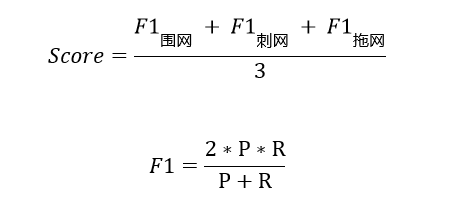

其中P为某类别的准确率，R为某类别的召回率，评测程序f1函数为sklearn.metrics.f1_score，average='macro'。

In [1]:
!ls /home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/

hy_round1_testA_20200102  hy_round1_train_20200102
hy_round1_testB_20200221  hy_round2_train_20200225


In [84]:
!ls -lh /home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/ | head

总用量 193M
-rw-r--r-- 1 lyz lyz  27K 1月   2  2020 0.csv
-rw-r--r-- 1 lyz lyz  26K 1月   2  2020 1000.csv
-rw-r--r-- 1 lyz lyz  29K 1月   2  2020 1001.csv
-rw-r--r-- 1 lyz lyz  28K 1月   2  2020 1002.csv
-rw-r--r-- 1 lyz lyz  28K 1月   2  2020 1003.csv
-rw-r--r-- 1 lyz lyz  26K 1月   2  2020 1004.csv
-rw-r--r-- 1 lyz lyz  27K 1月   2  2020 1005.csv
-rw-r--r-- 1 lyz lyz  28K 1月   2  2020 1006.csv
-rw-r--r-- 1 lyz lyz  28K 1月   2  2020 1007.csv
ls: 写入错误: 断开的管道


In [12]:
!head /home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/20.csv

渔船ID,x,y,速度,方向,time,type
20,6896876.166289244,5608366.3111367095,0.32,313,1106 23:55:32,围网
20,6897164.539275251,5608492.343146438,0.11,336,1106 23:25:04,围网
20,6897164.539275251,5608492.343146438,0.0,294,1106 23:15:07,围网
20,6897262.289838243,5608497.610992314,0.0,310,1106 23:04:59,围网
20,6897360.0402409285,5608502.87981675,0.22,279,1106 22:54:59,围网
20,6897360.0402409285,5608502.87981675,0.11,299,1106 22:44:58,围网
20,6897457.790483274,5608508.149619745,0.0,123,1106 22:34:59,围网
20,6897457.790483274,5608508.149619745,0.11,311,1106 22:24:56,围网
20,6897457.790483274,5608508.149619745,0.0,139,1106 22:14:51,围网


In [8]:
import os, sys, glob
import numpy as np
import pandas as pd

import time
import datetime

from joblib import Parallel, delayed
from sklearn.metrics import f1_score, log_loss, classification_report
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
PATH = '/home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/'

['/home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/2043.csv',
 '/home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/4330.csv',
 '/home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/4664.csv',
 '/home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/4454.csv',
 '/home/lyz/work/kaggle/2020数字中国创新大赛—算法赛：智慧海洋建设/hy_round1_train_20200102/102.csv']

In [16]:
[pd.read_csv(x) 
 for x in glob.glob(PATH + 'hy_round1_train_20200102' + '/*.csv')[:2]]

[     渔船ID             x             y    速度   方向           time type
 0    2043  6.102567e+06  5.064173e+06  4.37   76  1117 11:57:09   拖网
 1    2043  6.101846e+06  5.063865e+06  0.16    0  1117 11:46:11   拖网
 2    2043  6.101950e+06  5.063971e+06  1.57  131  1117 11:36:12   拖网
 3    2043  6.101341e+06  5.064205e+06  2.05   74  1117 11:26:12   拖网
 4    2043  6.100316e+06  5.064015e+06  4.16   82  1117 11:16:12   拖网
 ..    ...           ...           ...   ...  ...            ...  ...
 404  2043  6.102550e+06  5.112648e+06  0.05    0  1114 12:46:24   拖网
 405  2043  6.102550e+06  5.112648e+06  0.00    0  1114 12:36:25   拖网
 406  2043  6.102550e+06  5.112648e+06  0.00    0  1114 12:26:25   拖网
 407  2043  6.102550e+06  5.112648e+06  0.00    0  1114 12:16:25   拖网
 408  2043  6.102550e+06  5.112648e+06  0.00    0  1114 12:08:07   拖网
 
 [409 rows x 7 columns],
      渔船ID             x             y    速度   方向           time type
 0    4330  6.252970e+06  5.250924e+06  0.11  310  1123 23:53:2

In [18]:
hy_round1_train = [pd.read_csv(x) 
                   for x in glob.glob(PATH + 'hy_round1_train_20200102' + '/*.csv')]

In [21]:
hy_round1_train[0].shape, hy_round1_train[1].shape

((409, 7), (317, 7))

In [23]:
hy_round1_train = pd.concat(hy_round1_train)
hy_round1_train.head()

hy_round1_train['time'] = pd.to_datetime(hy_round1_train['time'], 
                                         format='%m%d %H:%M:%S')
hy_round1_train = hy_round1_train.sort_values(['渔船ID', 'time'])

渔船ID             x             y    速度   方向           time type
0  2043  6.102567e+06  5.064173e+06  4.37   76  1117 11:57:09   拖网
1  2043  6.101846e+06  5.063865e+06  0.16    0  1117 11:46:11   拖网
2  2043  6.101950e+06  5.063971e+06  1.57  131  1117 11:36:12   拖网
3  2043  6.101341e+06  5.064205e+06  2.05   74  1117 11:26:12   拖网
4  2043  6.100316e+06  5.064015e+06  4.16   82  1117 11:16:12   拖网

In [65]:
hy_round1_train['time'] = pd.to_datetime(hy_round1_train['time'], format='%m%d %H:%M:%S')

In [69]:
hy_round1_train['time_hour'] = hy_round1_train['time'].dt.hour

In [24]:
hy_round1_train['type'].value_counts()

拖网    1681225
围网     626607
刺网     391806
Name: type, dtype: int64

In [25]:
hy_round1_train['x'].describe()

count    2.699638e+06
mean     6.277243e+06
std      2.698065e+05
min      5.000250e+06
25%      6.118054e+06
50%      6.246522e+06
75%      6.365916e+06
max      7.133785e+06
Name: x, dtype: float64

In [26]:
hy_round1_train['y'].describe()

count    2.699638e+06
mean     5.271190e+06
std      2.544160e+05
min      3.345433e+06
25%      5.114766e+06
50%      5.229463e+06
75%      5.379267e+06
max      7.667581e+06
Name: y, dtype: float64

In [27]:
hy_round1_train['速度'].describe()

count    2.699638e+06
mean     1.784449e+00
std      2.478862e+00
min      0.000000e+00
25%      1.100000e-01
50%      3.200000e-01
75%      3.290000e+00
max      1.001600e+02
Name: 速度, dtype: float64

In [47]:
df = hy_round1_train[hy_round1_train['渔船ID'] == 0]

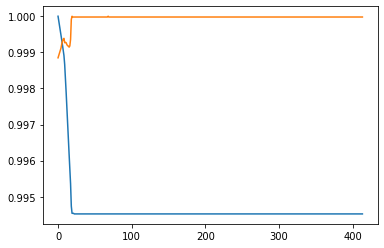

In [50]:
plt.plot(df[['x', 'y']])

In [66]:
hy_round1_train

渔船ID             x             y    速度   方向                time type
413     0  6.118352e+06  5.130672e+06  0.00    0 1900-11-07 12:09:28   拖网
412     0  6.118352e+06  5.130672e+06  0.00    0 1900-11-07 12:18:30   拖网
411     0  6.118352e+06  5.130672e+06  0.00    0 1900-11-07 12:28:32   拖网
410     0  6.118352e+06  5.130672e+06  0.00    0 1900-11-07 12:38:32   拖网
409     0  6.118352e+06  5.130672e+06  0.00    0 1900-11-07 12:48:30   拖网
..    ...           ...           ...   ...  ...                 ...  ...
4    6999  6.236923e+06  5.229676e+06  0.00  198 1900-11-20 23:09:30   拖网
3    6999  6.236923e+06  5.229676e+06  0.32   81 1900-11-20 23:19:35   拖网
2    6999  6.236923e+06  5.229676e+06  0.22  266 1900-11-20 23:29:52   拖网
1    6999  6.236923e+06  5.229676e+06  0.32    0 1900-11-20 23:39:43   拖网
0    6999  6.236923e+06  5.229676e+06  0.32   20 1900-11-20 23:49:44   拖网

[2699638 rows x 7 columns]

In [54]:
hy_round1_train.groupby('渔船ID')['x'].mean()

渔船ID
0       6.119351e+06
1       6.091460e+06
2       6.183011e+06
3       5.239159e+06
4       7.062005e+06
            ...     
6995    6.290575e+06
6996    6.463527e+06
6997    5.240222e+06
6998    6.373425e+06
6999    6.235427e+06
Name: x, Length: 7000, dtype: float64

In [55]:
hy_round1_train.groupby('渔船ID')['y'].mean()

渔船ID
0       5.130494e+06
1       5.094050e+06
2       5.193682e+06
3       4.601532e+06
4       6.116389e+06
            ...     
6995    5.207884e+06
6996    5.460851e+06
6997    4.600819e+06
6998    5.395488e+06
6999    5.223171e+06
Name: y, Length: 7000, dtype: float64

In [70]:
hy_round1_train.groupby(['渔船ID']).agg({
    'x': ['min', 'max', 'mean'],
    'y': ['min', 'max', 'mean'],
    '速度': ['min', 'max', 'mean'],
    '方向': ['min', 'max', 'mean'],
    'time_hour': ['min', 'max', 'nunique']
})

x                                         y                \
               min           max          mean           min           max   
渔船ID                                                                         
0     6.118352e+06  6.152038e+06  6.119351e+06  5.124873e+06  5.130781e+06   
1     6.049472e+06  6.102450e+06  6.091460e+06  5.042857e+06  5.112874e+06   
2     6.182482e+06  6.183191e+06  6.183011e+06  5.193576e+06  5.193696e+06   
3     5.228590e+06  5.287805e+06  5.239159e+06  4.577467e+06  4.608628e+06   
4     7.049394e+06  7.070797e+06  7.062005e+06  6.094996e+06  6.136033e+06   
...            ...           ...           ...           ...           ...   
6995  6.233906e+06  6.333177e+06  6.290575e+06  5.150309e+06  5.251166e+06   
6996  6.432284e+06  6.494482e+06  6.463527e+06  5.432442e+06  5.494745e+06   
6997  5.228700e+06  5.287462e+06  5.240222e+06  4.577723e+06  4.608628e+06   
6998  6.365020e+06  6.387625e+06  6.373425e+06  5.343505e+06  5.423379e+06   
6999  6.206373e+06  6.240317e+06  6.235427e+06  5.132028e+06  5.229791e+06   

                      速度                   方向                  time_hour      \
              mean   min    max      mean min  max        mean       min max   
渔船ID                                                                           
0     5.130494e+06  0.00   9.39  0.265966   0  129    4.613527         0  23   
1     5.094050e+06  0.00  10.47  1.607922   0  336   56.153247         0  23   
2     5.193682e+06  0.00  50.46  0.595150   0  360  123.356223         0  23   
3     4.601532e+06  0.00  10.09  1.471343   0  352  121.134328         0  23   
4     6.116389e+06  0.00  10.09  1.412219   0  359  139.067332         0  23   
...            ...   ...    ...       ...  ..  ...         ...       ...  ..   
6995  5.207884e+06  0.00  10.09  3.085375   0  360  147.584375         0  23   
6996  5.460851e+06  0.27   8.85  3.026945   0  358  153.456919         0  23   
6997  4.600819e+06  0.00  10.09  1.501083   0  354  137.589172         0  23   
6998  5.395488e+06  0.00   9.88  1.959383   0  360  137.469136         0  23   
6999  5.223171e+06  0.00  10.09  0.959448   0  360   83.570743         0  23   

              
     nunique  
渔船ID          
0         24  
1         24  
2         24  
3         24  
4         24  
...      ...  
6995      24  
6996      24  
6997      24  
6998      24  
6999      24  

[7000 rows x 15 columns]

In [71]:
def read_feat(path, test_mode=False):
    df = pd.read_csv(path)
    df = df.iloc[::-1]
    
    if test_mode:
        df_feat = [df['渔船ID'].iloc[0], df['type'].iloc[0]]
        df = df.drop(['type'], axis=1)
    else:
        df_feat = [df['渔船ID'].iloc[0]]
        
    df['time'] = df['time'].apply(lambda x: datetime.datetime.strptime(x, "%m%d %H:%M:%S"))
    df_diff = df.diff(1).iloc[1:]
    df_diff['time_seconds'] = df_diff['time'].dt.total_seconds()
    df_diff['dis'] = np.sqrt(df_diff['x']**2 + df_diff['y']**2)
    
    df_feat.append(df['time'].dt.day.nunique())
    df_feat.append(df['time'].dt.hour.min())
    df_feat.append(df['time'].dt.hour.max())
    df_feat.append(df['time'].dt.hour.value_counts().index[0])

    df_feat.append(df['速度'].min())
    df_feat.append(df['速度'].max())
    df_feat.append(df['速度'].mean())

    df_feat.append(df_diff['速度'].min())
    df_feat.append(df_diff['速度'].max())
    df_feat.append(df_diff['速度'].mean())
    df_feat.append((df_diff['速度'] > 0).mean())
    df_feat.append((df_diff['速度'] == 0).mean())

    df_feat.append(df_diff['方向'].min())
    df_feat.append(df_diff['方向'].max())
    df_feat.append(df_diff['方向'].mean())
    df_feat.append((df_diff['方向'] > 0).mean())
    df_feat.append((df_diff['方向'] == 0).mean())

    df_feat.append((df_diff['x'].abs() / df_diff['time_seconds']).min())
    df_feat.append((df_diff['x'].abs() / df_diff['time_seconds']).max())
    df_feat.append((df_diff['x'].abs() / df_diff['time_seconds']).mean())
    df_feat.append((df_diff['x'] > 0).mean())
    df_feat.append((df_diff['x'] == 0).mean())

    df_feat.append((df_diff['y'].abs() / df_diff['time_seconds']).min())
    df_feat.append((df_diff['y'].abs() / df_diff['time_seconds']).max())
    df_feat.append((df_diff['y'].abs() / df_diff['time_seconds']).mean())
    df_feat.append((df_diff['y'] > 0).mean())
    df_feat.append((df_diff['y'] == 0).mean())
    
    df_feat.append(df_diff['dis'].min())
    df_feat.append(df_diff['dis'].max())
    df_feat.append(df_diff['dis'].mean())

    df_feat.append((df_diff['dis']/df_diff['time_seconds']).min())
    df_feat.append((df_diff['dis']/df_diff['time_seconds']).max())
    df_feat.append((df_diff['dis']/df_diff['time_seconds']).mean())
    
    return df_feat

In [72]:
read_feat(glob.glob(PATH + 'hy_round1_train_20200102' + '/*.csv')[0], True)

[2043,
 '拖网',
 4,
 0,
 23,
 23,
 0.0,
 8.85,
 2.624547677261613,
 -5.23,
 8.2,
 0.010710784313725475,
 0.41421568627450983,
 0.18627450980392157,
 -350.0,
 350.0,
 0.18627450980392157,
 0.3602941176470588,
 0.3235294117647059,
 0.0,
 2.8400450109612816,
 0.7450670351534723,
 0.3333333333333333,
 0.30392156862745096,
 0.0,
 4.237975838899434,
 0.8271564731827773,
 0.32107843137254904,
 0.30392156862745096,
 0.0,
 5454.9516070932,
 850.1544857295838,
 0.0,
 4.324149769961696,
 1.327188210852849]

In [79]:
%%time
train_feat = Parallel(n_jobs=10)(delayed(read_feat)(path, True) 
                    for path in glob.glob(PATH + 'hy_round1_train_20200102' + '/*.csv')[:500])
train_feat = pd.DataFrame(train_feat)

test_feat = Parallel(n_jobs=10)(delayed(read_feat)(path, False) 
                    for path in glob.glob(PATH + 'hy_round1_testA_20200102' + '/*.csv')[:500])
test_feat = pd.DataFrame(test_feat)
test_feat = test_feat.sort_values(by=0)

CPU times: user 885 ms, sys: 238 ms, total: 1.12 s
Wall time: 4.11 s


In [78]:
%%time
train_feat = Parallel(n_jobs=1)(delayed(read_feat)(path, True) 
                    for path in glob.glob(PATH + 'hy_round1_train_20200102' + '/*.csv')[:500])
train_feat = pd.DataFrame(train_feat)

test_feat = Parallel(n_jobs=1)(delayed(read_feat)(path, False) 
                    for path in glob.glob(PATH + 'hy_round1_testA_20200102' + '/*.csv')[:500])
test_feat = pd.DataFrame(test_feat)
test_feat = test_feat.sort_values(by=0)

CPU times: user 11.8 s, sys: 13 ms, total: 11.8 s
Wall time: 11.8 s


In [80]:
%%time
train_feat = Parallel(n_jobs=10)(delayed(read_feat)(path, True) 
                    for path in glob.glob(PATH + 'hy_round1_train_20200102' + '/*.csv')[:])
train_feat = pd.DataFrame(train_feat)

test_feat = Parallel(n_jobs=10)(delayed(read_feat)(path, False) 
                    for path in glob.glob(PATH + 'hy_round1_testA_20200102' + '/*.csv')[:])
test_feat = pd.DataFrame(test_feat)
test_feat = test_feat.sort_values(by=0)

CPU times: user 3.18 s, sys: 374 ms, total: 3.56 s
Wall time: 19.7 s


In [81]:
train_feat[1] = train_feat[1].map({'围网':0,'刺网':1,'拖网':2})

In [82]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

n_fold = 10
skf = StratifiedKFold(n_splits = n_fold, shuffle = True)
eval_fun = f1_score

def run_oof(clf, X_train, y_train, X_test, kf):
    print(clf)
    preds_train = np.zeros((len(X_train), 3), dtype = np.float)
    preds_test = np.zeros((len(X_test), 3), dtype = np.float)
    train_loss = []; test_loss = []

    i = 1
    for train_index, test_index in kf.split(X_train, y_train):
        x_tr = X_train[train_index]; x_te = X_train[test_index]
        y_tr = y_train[train_index]; y_te = y_train[test_index]
        clf.fit(x_tr, y_tr, eval_set = [(x_te, y_te)], early_stopping_rounds = 500, verbose = False)
        
        train_loss.append(eval_fun(y_tr, np.argmax(clf.predict_proba(x_tr)[:], 1), average='macro'))
        test_loss.append(eval_fun(y_te, np.argmax(clf.predict_proba(x_te)[:], 1), average='macro'))

        preds_train[test_index] = clf.predict_proba(x_te)[:]
        preds_test += clf.predict_proba(X_test)[:]

        print('{0}: Train {1:0.7f} Val {2:0.7f}/{3:0.7f}'.format(i, train_loss[-1], test_loss[-1], np.mean(test_loss)))
        print('-' * 50)
        i += 1
    print('Train: ', train_loss)
    print('Val: ', test_loss)
    print('-' * 50)
    print('Train{0:0.5f}_Test{1:0.5f}\n\n'.format(np.mean(train_loss), np.mean(test_loss)))
    preds_test /= n_fold
    return preds_train, preds_test

In [83]:
params = {
    'learning_rate': 0.01,
    'min_child_samples': 5,
    'max_depth': 7,
    'lambda_l1': 2,
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'n_estimators': 2000,
    'metric': 'multi_error',
    'num_class': 3,
    'feature_fraction': .75,
    'bagging_fraction': .85,
    'seed': 99,
    'num_threads': 20,
    'verbose': -1
}

train_pred, test_pred = run_oof(lgb.LGBMClassifier(**params), 
                                train_feat.iloc[:, 2:].values, 
                                train_feat.iloc[:, 1].values, 
                                test_feat.iloc[:, 1:].values, 
                                skf)


LGBMClassifier(bagging_fraction=0.85, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.75,
               importance_type='split', lambda_l1=2, learning_rate=0.01,
               max_depth=7, metric='multi_error', min_child_samples=5,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_class=3, num_leaves=31, num_threads=20,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=99, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] num_threads is set=20, n_jobs=-1 will be ignored. Current value: num_threads=20
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] 

In [ ]:
test_feat['label'] = np.argmax(test_pred, 1)
test_feat['label'] = test_feat['label'].map({0:'围网',1:'刺网',2:'拖网'})